# Example of how to use Deep Learning for text classification

Click [Text Classification Example](https://colab.research.google.com/github/magic-lantern/coprh-nlp-2021/blob/main/text_classification_colab.ipynb) to open this notebook in Google Colab - no local setup required, results saved to your Google Drive.

In Google Colab, make sure you change the Runtime to a GPU instance - that will result vastly improved runtimes for deep learning steps. On CPU based hardware some steps take 40 minutes versus 1 minute per training epoch on systems with a GPU. Steps to update runtime:

    Runtime > Change runtime type > Select 'GPU' in Hardware accelerator box

Click 'Save' to switch from Default runtime to GPU accelerated runtime.

Some useful links:

* https://muellerzr.github.io/fastblog/2020/08/21/intermediate.html#A-Text-Example

In [1]:
# this cell makes sure Google Colab version has latest software dependencies
!pip install -Uqq fastbook fastai

In [2]:
import gc

In [3]:
# this cell will setup a path that allows you to load and save files to your google drive
# you will be prompted to log in with a Google enabled account.
import fastbook
fastbook.setup_book()

In [4]:
from fastai.text.all import *

In [5]:
Path.cwd()

Path('/home/sethr/coprh-nlp-2021')

In [6]:
# outside Google Colab, I'm not using fastbook
if 'fastbook' in vars() or 'fastbook' in globals():
    data_path = fastbook.gdrive / Path('data')
    model_path = fastbook.gdrive / Path('models')
else:
    data_path = Path.cwd() / Path('data')
    model_path = Path.cwd() / Path('models')
data_file = data_path / 'mtsamples.csv'
sequence_length = 512

In [7]:
data_file

Path('/home/sethr/coprh-nlp-2021/data/mtsamples.csv')

In [8]:
if data_file.is_file():
    print('Already downloaded')
else:
    print('downloading data file')
    download_data(
        url='https://github.com/socd06/medical-nlp/raw/master/data/mtsamples.csv',
        fname = data_file
    )

Already downloaded


In [9]:
mtsamples = pd.read_csv(str(data_path) + '/mtsamples.csv')
# remove leading/trailing spaces from text fields
mtsamples = mtsamples.applymap(lambda x: x.strip() if isinstance(x, str) else x)
mtsamples.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with complaint of allergies.,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female presents with complaint of allergies. She used to have allergies when she lived in Seattle but she thinks they are worse here. In the past, she has tried Claritin, and Zyrtec. Both worked for short time but then seemed to lose effectiveness. She has used Allegra also. She used that last summer and she began using it again two weeks ago. It does not appear to be working very well. She has used over-the-counter sprays but no prescription nasal sprays. She does have asthma but doest not require daily medication for this and does not think it...","allergy / immunology, allergic rhinitis, allergies, asthma, nasal sprays, rhinitis, nasal, erythematous, allegra, sprays, allergic,"
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. He exercises three times a week at home and does cardio. He has difficulty walking two blocks or five flights of stairs. Difficulty with snoring. He has muscle and joint pains including knee pain, back pain, foot and ankle pain, and swelling. He has gastroesophageal reflux disease.,PAST SURGICAL HISTORY:, Includes reconstructive surgery on his right hand 13 years ago. ,SOCIAL HISTORY:, He is currently single. He has about te...","bariatrics, laparoscopic gastric bypass, weight loss programs, gastric bypass, atkin's diet, weight watcher's, body weight, laparoscopic gastric, weight loss, pounds, months, weight, laparoscopic, band, loss, diets, overweight, lost"
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC today. He is a very pleasant gentleman who is 42 years old, 344 pounds. He is 5'9"". He has a BMI of 51. He has been overweight for ten years since the age of 33, at his highest he was 358 pounds, at his lowest 260. He is pursuing surgical attempts of weight loss to feel good, get healthy, and begin to exercise again. He wants to be able to exercise and play volleyball. Physically, he is sluggish. He gets tired quickly. He does not go out often. When he loses weight he always regains it and he gains back more than he lost. His biggest...","bariatrics, laparoscopic gastric bypass, heart attacks, body weight, pulmonary embolism, potential complications, sleep study, weight loss, gastric bypass, anastomosis, loss, sleep, laparoscopic, gastric, bypass, heart, pounds, weight,"
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement with left atrial diameter of 4.7 cm.,2. Normal size right and left ventricle.,3. Normal LV systolic function with left ventricular ejection fraction of 51%.,4. Normal LV diastolic function.,5. No pericardial effusion.,6. Normal morphology of aortic valve, mitral valve, tricuspid valve, and pulmonary valve.,7. PA systolic pressure is 36 mmHg.,DOPPLER: , ,1. Mild mitral and tricuspid regurgitation.,2. Trace aortic and pulmonary regurgitation.","cardiovascular / pulmonary, 2-d m-mode, doppler, aortic valve, atrial enlargement, diastolic function, ejection fraction, mitral, mitral valve, pericardial effusion, pulmonary valve, regurgitation, systolic function, tricuspid, tricuspid valve, normal lv"
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,"1. The left ventricular cavity size and wall thickness appear normal. The wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of 70% to 75%. There is near-cavity obliteration seen. There also appears to be increased left ventricular outflow tract gradient at the mid cavity level consiste

### Setup objects for Language Model Training

This is one way to load the data for training - it's more simple, but you have less control.

```python
TextDataLoaders.from_df(mtsamples,
                        valid_pct=0.2,
                        seed=42,
                        text_col='transcription',
                        label_col='medical_specialty',
                        seq_len=72)
```

In [10]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df('transcription', is_lm=True),
    get_x=ColReader('text'),
    splitter=TrainTestSplitter(test_size=0.2,
                               random_state=42)
)

In [11]:
# This cell takes 1 - 2 minutes
# when using seq_len of 256, bs of 128 fits in GPU memory, bs 256 does not fit
# when using seq_len of 512, bs of 64 fits in GPU memory, bs 128 does not fit
dls_lm = dls_lm.dataloaders(mtsamples, bs=32, seq_len=sequence_length)

/opt/miniconda3/envs/coprh/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## Train the language Model

This portion can be skipped if done previously

In [12]:
# if changes in the above were made (such as batch size), it may be beneficial to purge GPU memory
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [13]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxup history xxup of xxup present xxup illness : , xxmaj ms . a is a 55 - year - old female who presented to the xxmaj bariatric xxmaj surgery xxmaj service for consideration of laparoscopic roux - en - y gastric bypass . xxmaj the patient states that she has been overweight for approximately 35 years and has tried multiple weight loss modalities in the past including xxmaj weight xxmaj watchers , xxunk , xxmaj xxunk xxmaj craig , xxup xxunk , xxunk diet , grape fruit diet , slim - fast , xxmaj richard xxmaj xxunk , as well as over - the - counter measures without any long - term xxunk weight loss . xxmaj at the time of presentation to the practice , she is 5 feet 6 inches tall with a weight of xxunk pounds and a body mass index of 46 . xxmaj","xxup history xxup of xxup present xxup illness : , xxmaj ms . a is a 55 - year - old female who presented to the xxmaj bariatric xxmaj surgery xxmaj service for consideration of laparoscopic roux - en - y gastric bypass . xxmaj the patient states that she has been overweight for approximately 35 years and has tried multiple weight loss modalities in the past including xxmaj weight xxmaj watchers , xxunk , xxmaj xxunk xxmaj craig , xxup xxunk , xxunk diet , grape fruit diet , slim - fast , xxmaj richard xxmaj xxunk , as well as over - the - counter measures without any long - term xxunk weight loss . xxmaj at the time of presentation to the practice , she is 5 feet 6 inches tall with a weight of xxunk pounds and a body mass index of 46 . xxmaj she"
1,"she did choose to take then she would choose to cancel xxmaj friday ’s appointment , also that she would not feel too badly over the holiday weekend . i thought that was reasonable and agreed that that would work out . ,procedure : , : xxmaj she was then given 10 mg of morphine subcutaneously because she did not feel she could tolerate the discomfort in the instillation without pain medicine . xxmaj we waited about 20 minutes . xxmaj the bladder was then instilled and the urethra was instilled with lidocaine gel which she tolerated and then after a 10 - minute wait , the bladder was instilled with xxup xxunk , xxmaj kenalog , heparin , and sodium bicarbonate , and the catheter was removed . xxmaj the patient retained the solution for one hour , changing position every 15 minutes and then voided to empty the","did choose to take then she would choose to cancel xxmaj friday ’s appointment , also that she would not feel too badly over the holiday weekend . i thought that was reasonable and agreed that that would work out . ,procedure : , : xxmaj she was then given 10 mg of morphine subcutaneously because she did not feel she could tolerate the discomfort in the instillation without pain medicine . xxmaj we waited about 20 minutes . xxmaj the bladder was then instilled and the urethra was instilled with lidocaine gel which she tolerated and then after a 10 - minute wait , the bladder was instilled with xxup xxunk , xxmaj kenalog , heparin , and sodium bicarbonate , and the catheter was removed . xxmaj the patient retained the solution for one hour , changing position every 15 minutes and then voided to empty the bladder"


In [14]:
lm_learn = language_model_learner(
    dls_lm,
    AWD_LSTM,
    model_dir=model_path,
    drop_mult=0.3,
    metrics=[accuracy, Perplexity()]).to_fp16()

In [15]:
# on macbook this cell takes 40 minues
# on GPU machine this cell takes about 1 minute
lm_learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.266061,2.974056,0.441138,19.571144,00:39


In [16]:
lm_learn.save('lm_1stepoch')
# can load already saved trained model with
# learn.load('1stepoch')

Path('/home/sethr/coprh-nlp-2021/models/lm_1stepoch.pth')

In [17]:
# if changes in the above were made (such as batch size), it may be beneficial to purge GPU memory
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [18]:
# train language model until we get to about 85% accuracy
# each epoch takes about 1 minute
lm_learn.unfreeze()
lm_learn.fit_one_cycle(30, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.863827,2.869481,0.454325,17.627861,00:41
1,2.776455,2.769475,0.466248,15.950257,00:40
2,2.638583,2.641953,0.483763,14.040598,00:41
3,2.480408,2.496657,0.503286,12.141831,00:41
4,2.294246,2.340539,0.527089,10.386828,00:41
5,2.090474,2.190485,0.551739,8.939546,00:41
6,1.882048,2.035991,0.580387,7.659837,00:41
7,1.666690,1.881606,0.609787,6.564037,00:42
8,1.486784,1.754969,0.636988,5.783270,00:41
9,1.307533,1.637432,0.661955,5.141949,00:41


In [19]:
lm_learn.save_encoder('lm_finetuned')

In [20]:
? lm_learn.load()

Object ` lm_learn.load()` not found.


In [22]:
# can load with
# lm_learn = lm_learn.load('lm_finetuned')

## Now build a text classifier

Now that we have finetuned a language model based on our actual text let's build a classifier to identify the medical specialty of the transcription notes. As shown previously in this dataset, some specialties are more represented than others. Split data such that training and testing data sets are balanced based on specialty.

A note on data cleanup: In the best case, a machine learning model can only be as good as the data provided. If data is of poor quality or labels are inconsistent, it will be difficult to get good accuracy with your model.

Let's review the really short transcription notes.

In [23]:
word_len = mtsamples.transcription.str.split(' ').str.len()

In [24]:
mtsamples['num_words'] =  mtsamples.transcription.str.split(' ').str.len()

In [25]:
word_len.median()

425.0

In [26]:
word_len.min()

1.0

In [27]:
word_len.std()

333.8242317381962

In [28]:
print(f"There are {len(mtsamples[mtsamples['num_words'] < 5])} records with short notes.")
mtsamples[mtsamples['num_words'] < 5].head()

There are 16 records with short notes.


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords,num_words
24,24,Blood in urine - Transitional cell cancer of the bladder.,Urology,Urology Consut - 1,"CHIEF COMPLAINT:,",NaN,2.0
872,872,EGD with dilation for dysphagia.,Surgery,EGD with Dilation,"INDICATION: ,","surgery, egd, hurricaine spray, olympus endoscope, savary wire, cricopharyngeus, decubitus, dilator, duodenum, dysphagia, esophagus, hiatal hernia, peptic, pylorus, stomach, tortuosity, egd with dilation, tortuous, scope, hiatal, hernia,",3.0
1379,1379,Sample progress note - Gen Med.,SOAP / Chart / Progress Notes,Gen Med SOAP - 1,"SUBJECTIVE:,","soap / chart / progress notes, progress note, clear to auscultation, s1, s2, s3, s4, blood pressure, clubbing, cyanosis, general medicine, peripheral edema, rubs, tenderness, abdomen, pressure, soap, blood",1.0
1525,1525,Dobutrex stress test for abnormal EKG,Radiology,Stress Test Dobutrex,"INDICATIONS:,","radiology, dobutrex stress test, abnormal ekg, dobutrex, inferior abnormality, ischemic heart disease, ventricle, µg/kg/minute, stress test, stress,",1.0
1949,1949,Trigger Point Injection. The area over the myofascial spasm was prepped with alcohol utilizing sterile technique.,Pain Management,Trigger Point Injection,"OPERATION:,","pain management, myofascial spasm, trigger point injection, trigger, injection, spasm",1.0


In [29]:
# keep transcripts with 5 or more words
mtsamples = mtsamples[mtsamples['num_words'] >= 5]

In [30]:
mtsamples.medical_specialty.value_counts()

Surgery                          1087
Consult - History and Phy.        515
Cardiovascular / Pulmonary        370
Orthopedic                        352
Radiology                         272
General Medicine                  258
Neurology                         223
Gastroenterology                  223
SOAP / Chart / Progress Notes     165
Obstetrics / Gynecology           155
Urology                           155
Discharge Summary                 108
ENT - Otolaryngology               96
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    59
Psychiatry / Psychology            53
Office Notes                       48
Podiatry                           47
Dermatology                        29
Cosmetic / Plastic Surgery         27
Dentistry                          27
Letters     

All machine learning models require a few examples to be able to train from. In this dataset, we will combine those categories with less than 50 examples into an 'Other' category. Later those more rare categories can be dealt with separately.

In [31]:
mtsamples['counts'] = mtsamples.groupby(['medical_specialty'])['transcription'].transform('count')

In [32]:
mtsamples.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords,num_words,counts
0,0,A 23-year-old white female presents with complaint of allergies.,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female presents with complaint of allergies. She used to have allergies when she lived in Seattle but she thinks they are worse here. In the past, she has tried Claritin, and Zyrtec. Both worked for short time but then seemed to lose effectiveness. She has used Allegra also. She used that last summer and she began using it again two weeks ago. It does not appear to be working very well. She has used over-the-counter sprays but no prescription nasal sprays. She does have asthma but doest not require daily medication for this and does not think it...","allergy / immunology, allergic rhinitis, allergies, asthma, nasal sprays, rhinitis, nasal, erythematous, allegra, sprays, allergic,",226.0,7
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. He exercises three times a week at home and does cardio. He has difficulty walking two blocks or five flights of stairs. Difficulty with snoring. He has muscle and joint pains including knee pain, back pain, foot and ankle pain, and swelling. He has gastroesophageal reflux disease.,PAST SURGICAL HISTORY:, Includes reconstructive surgery on his right hand 13 years ago. ,SOCIAL HISTORY:, He is currently single. He has about te...","bariatrics, laparoscopic gastric bypass, weight loss programs, gastric bypass, atkin's diet, weight watcher's, body weight, laparoscopic gastric, weight loss, pounds, months, weight, laparoscopic, band, loss, diets, overweight, lost",375.0,18
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC today. He is a very pleasant gentleman who is 42 years old, 344 pounds. He is 5'9"". He has a BMI of 51. He has been overweight for ten years since the age of 33, at his highest he was 358 pounds, at his lowest 260. He is pursuing surgical attempts of weight loss to feel good, get healthy, and begin to exercise again. He wants to be able to exercise and play volleyball. Physically, he is sluggish. He gets tired quickly. He does not go out often. When he loses weight he always regains it and he gains back more than he lost. His biggest...","bariatrics, laparoscopic gastric bypass, heart attacks, body weight, pulmonary embolism, potential complications, sleep study, weight loss, gastric bypass, anastomosis, loss, sleep, laparoscopic, gastric, bypass, heart, pounds, weight,",774.0,18
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement with left atrial diameter of 4.7 cm.,2. Normal size right and left ventricle.,3. Normal LV systolic function with left ventricular ejection fraction of 51%.,4. Normal LV diastolic function.,5. No pericardial effusion.,6. Normal morphology of aortic valve, mitral valve, tricuspid valve, and pulmonary valve.,7. PA systolic pressure is 36 mmHg.,DOPPLER: , ,1. Mild mitral and tricuspid regurgitation.,2. Trace aortic and pulmonary regurgitation.","cardiovascular / pulmonary, 2-d m-mode, doppler, aortic valve, atrial enlargement, diastolic function, ejection fraction, mitral, mitral valve, pericardial effusion, pulmonary valve, regurgitation, systolic function, tricuspid, tricuspid valve, normal lv",77.0,370
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,"1. The left ventricular cavity size and wall thickness appear normal. The wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of 70% to 75%. There is near-cavity obliteration seen. There also appears to be increased left ventricular out

In [33]:
# for now just drop the infrequent categories
mtsamples = mtsamples[mtsamples.counts >= 100]

In [34]:
# as surgery and general medicine actuallly overlap with many of the other note types, drop these
mtsamples = mtsamples[mtsamples.medical_specialty != 'Surgery']
mtsamples = mtsamples[mtsamples.medical_specialty != 'General Medicine']

In [35]:
mtsamples.medical_specialty.value_counts()

Consult - History and Phy.       515
Cardiovascular / Pulmonary       370
Orthopedic                       352
Radiology                        272
Neurology                        223
Gastroenterology                 223
SOAP / Chart / Progress Notes    165
Urology                          155
Obstetrics / Gynecology          155
Discharge Summary                108
Name: medical_specialty, dtype: int64

In [36]:
# if changes in the above were made (such as batch size), it may be beneficial to purge GPU memory
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [37]:
# this cell takes about 2 minutes to run
dls_clas = DataBlock(
    blocks=(TextBlock.from_df('transcription', vocab=dls_lm.vocab), CategoryBlock),
    get_x=ColReader('text'),
    get_y=ColReader('medical_specialty'),
#     splitter=TrainTestSplitter(test_size=0.2,
#                                random_state=42)
    splitter=TrainTestSplitter(test_size=0.2,
                               random_state=42,
                               stratify=mtsamples.medical_specialty)
).dataloaders(mtsamples, bs=64, seq_len=sequence_length)

/opt/miniconda3/envs/coprh/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [38]:
dls_clas.show_batch(max_n=5)

,text,category
0,"xxbos xxup history xxup of xxup present xxup illness : , the patient is a 79 - year - old right - handed man who reports that approximately one and a half years ago , he fell down while walking in the living room from the bedroom . xxmaj at that time , he reports both legs gave away on him and he fell . xxmaj he reported that he had some lightheadedness just before he fell and was slightly confused , but was aware of what was happening around him . xxmaj he was able to get up shortly after falling and according to the patient and his son , subsequently returned back to normal . ,he was then well until the 3rd of xxmaj july 2008 when his legs again gave way on him . xxmaj this was not preceded by lightheadedness . xxmaj he was rushed to",Consult - History and Phy.
1,"xxbos xxup history xxup of xxup present xxup illness : , the patient is a 79 - year - old right - handed man who reports that approximately one and a half years ago , he fell down while walking in the living room from the bedroom . xxmaj at that time , he reports both legs gave away on him and he fell . xxmaj he reported that he had some lightheadedness just before he fell and was slightly confused , but was aware of what was happening around him . xxmaj he was able to get up shortly after falling and according to the patient and his son , subsequently returned back to normal . ,he was then well until the 3rd of xxmaj july 2008 when his legs again gave way on him . xxmaj this was not preceded by lightheadedness . xxmaj he was rushed to",Neurology
2,"xxbos xxup preoperative xxup diagnoses:,1 . xxmaj hallux abductovalgus , right foot . ,2 . xxmaj hammer toe , right foot , second , third , fourth and fifth toes . ,3 . xxmaj tailor 's bunionette , right foot . ,4 . xxmaj degenerative joint disease , right first metatarsophalangeal joint . ,5 . xxmaj rheumatoid arthritis . ,6 . xxmaj contracted fourth right metatarsophalangeal joint . ,postoperative xxup diagnoses:,1 . xxmaj hallux abductovalgus , right foot . ,2 . xxmaj hammer toe , right foot , second , third , fourth and fifth toes . ,3 . xxmaj tailor 's bunionette , right foot . ,4 . xxmaj degenerative joint disease , right first metatarsophalangeal joint . ,5 . xxmaj rheumatoid arthritis . ,6 . xxmaj contracted fourth right metatarsophalangeal joint . ,procedures xxup performed:,1 . xxmaj bunionectomy , right foot with xxmaj biopro hemi implant , right",Orthopedic
3,"xxbos xxup reason xxup for xxup referral : , xxmaj the patient is a 58 - year - old african - american right - handed female with 16 years of education who was referred for a neuropsychological evaluation by xxmaj dr . xxup x. xxmaj she is presenting for a second opinion following a recent neuropsychological evaluation that was ordered by her former place of employment that suggested that she was in the "" early stages of a likely dementia "" and was thereafter terminated from her position as a psychiatric nurse . a comprehensive evaluation was requested to assess current cognitive functioning and assist with diagnostic decisions and treatment planning . xxmaj note that this evaluation was undertaken as a clinical exam and intended for the purposes of aiding with treatment planning . xxmaj the patient was fully informed about the nature of this evaluation and intended use of",Consult - History and Phy.
4,"xxbos xxup preoperative xxup diagnoses:,1 . xxmaj clinical stage xxup t2 , xxup nx , xxup mx transitional cell carcinoma of the urinary bladder , status post chemotherapy and radiation therapy . ,2 . xxmaj new right hydronephrosis . ,postoperative xxup diagnoses:,1 . xxmaj clinical stage xxmaj xxunk , xxup n3 , xxup m1 transitional cell carcinoma of the urinary bladder , status post chemotherapy and radiation therapy . ,2 . xxmaj new right hydronephrosis . ,3 . xxmaj carcinoid tumor of the small bowel . ,title xxup of xxup operation : , xxmaj exploratory laparotomy , resection of small bowel lesion , biopsy of small bowel mesentery ,

In [39]:
learn = text_classifier_learner(
    dls_clas,
    AWD_LSTM,
    drop_mult=0.7, # if this is too low, validation loss does not improve with more training
    metrics=accuracy,
    model_dir=model_path).to_fp16()
# Without .to_fp16() requires more memory, takes about 2x - 3x time to train
# Accuracy is essentially unchanged with or without .to_fp16()

In [40]:
# load the encoder used for the language model - must be the same to build off language model.
learn = learn.load_encoder('lm_finetuned')

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.033113110810518265)

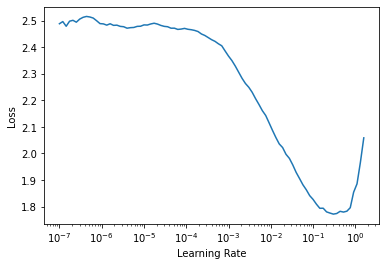

In [41]:
# attempt to find a decent learning rate for this dataset
learn.lr_find()

In [42]:
learn.fit_one_cycle(1, 4e-1)

epoch,train_loss,valid_loss,accuracy,time
0,2.051529,1.184890,0.580709,00:08


In [43]:
learn.save('class_part_1')

Path('/home/sethr/coprh-nlp-2021/models/class_part_1.pth')

In [44]:
# learn = learn.load('class_part_1')

In [45]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(3e-2/(2.6**4),3e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.145597,1.294086,0.600394,00:09


In [46]:
learn.save('class_part_2')

Path('/home/sethr/coprh-nlp-2021/models/class_part_2.pth')

In [47]:
# learn = learn.load('class_part_2')

In [48]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.991994,3.249447,0.610236,00:10


In [49]:
learn.save('class_part_3')

Path('/home/sethr/coprh-nlp-2021/models/class_part_3.pth')

In [50]:
learn = learn.load('class_part_3')

In [51]:
# now train all layers
learn.unfreeze()

SuggestedLRs(lr_min=5.754399462603033e-05, lr_steep=5.754399353463668e-06)

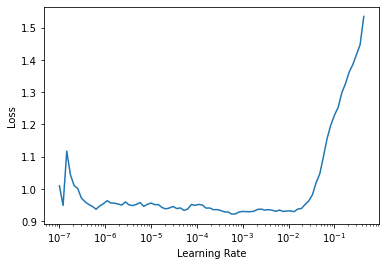

In [52]:
# attempt to find a decent learning rate for this dataset
learn.lr_find()

In [53]:
# now train all layers
# this takes about 30 seconds per epoch
# due to nature of dataset, more training doesn't help much
learn.fit_one_cycle(1, slice(1e-6/(2.6**4),1e-6))

epoch,train_loss,valid_loss,accuracy,time
0,0.955660,15.874542,0.602362,00:12


In [54]:
learn.save('class_full_part_1')

Path('/home/sethr/coprh-nlp-2021/models/class_full_part_1.pth')

In [55]:
learn.show_results()

,text,category,category_
0,"xxbos xxup reason xxup for xxup visit : , xxmaj the patient presents for a followup for history of erythema nodosum . ,history xxup of xxup present xxup illness : , xxmaj this is a 25 - year - old woman who is attending xxunk classes . xxmaj she was diagnosed with presumptive erythema nodosum in 2004 based on a biopsy consistent with erythema nodosum , but not entirely specific back in xxmaj xxunk . xxmaj at that point , she had undergone workup which was extensive for secondary diseases associated with erythema nodosum . xxmaj part of her workup included a colonoscopy . xxmaj the findings were equivocal xxunk not clearly abnormal biopsies of the terminal ileum . ,the skin biopsy , in particular , mentions some fibrosis , basal xxunk , and inflammatory cells in the subcutis . ,prior to the onset of her erythema nodosum , she",Consult - History and Phy.,Gastroenterology
1,"xxbos xxup type xxup of xxup consultation : , xxmaj wound care consult . ,history xxup of xxup present xxup illness : , xxmaj the patient is a 62 - year - old woman with a past medical history significant for prior ileojejunal bypass for weight loss ( 1980 ) and then subsequent gastric banding ( 2002 xxmaj dr . xxup x ) who was transferred to this facility following a complicated surgical and postoperative course after takedown of the prior xxunk and bypass ( 07 / 08 / 2008 , xxmaj dr . xxup y ) . xxmaj the patient has been followed by xxmaj cardiothoracic xxmaj surgery ( dr . xxup z ) as an outpatient . xxmaj she had a history of daily postprandial vomiting , regurgitation , and heartburn . xxmaj she underwent a preop assessment of her xxup gerd and postprandial vomiting including nuclear gastric",Consult - History and Phy.,Consult - History and Phy.
2,"xxbos xxup reason xxup for xxup referral : , xxmaj the patient is a 58 - year - old african - american right - handed female with 16 years of education who was referred for a neuropsychological evaluation by xxmaj dr . xxup x. xxmaj she is presenting for a second opinion following a recent neuropsychological evaluation that was ordered by her former place of employment that suggested that she was in the "" early stages of a likely dementia "" and was thereafter terminated from her position as a psychiatric nurse . a comprehensive evaluation was requested to assess current cognitive functioning and assist with diagnostic decisions and treatment planning . xxmaj note that this evaluation was undertaken as a clinical exam and intended for the purposes of aiding with treatment planning . xxmaj the patient was fully informed about the nature of this evaluation and intended use of",Neurology,Consult - History and Phy.
3,"xxbos xxup history xxup of xxup present xxup illness : , xxmaj the patient is a 35 - year - old woman who reports that on the xxunk of xxmaj october 2008 , she had a rupture of her membranes at nine months of pregnancy , and was admitted to hospital and was given an epidural anesthetic . i do not have the records from this hospital admission , but apparently the epidural was administered for approximately 14 to 18 hours . xxmaj she was sitting up during the epidural . ,she did not notice any difference in her lower extremities at the time she had the epidural ; however , she reports that she was extremely sleepy and may not have been aware of any change in strength or sensation in her lower extremities at that time . xxmaj she delivered on the 31st of xxmaj october , by",Neurology,Neurology
4,"xxbos xxup reason xxup for xxup referral : , xxmaj the patient was referred to me by xxmaj dr . x of the xxmaj clinic due to concerns regarding behavioral acting out as well as encopresis . xxmaj this is a 90 - minute initial intake completed on 10 / 03 / 2007 . i met with the patient 's mother individually for the entire session . i reviewed with her the treatment , consent form , as well as the boundaries of confidentiality , and she stated that she understood these concepts . ,p

In [56]:
interp = Interpretation.from_learner(learn)

In [57]:
interp.plot_top_losses(9, figsize=(15,10))

,input,target,predicted,probability,loss
0,"xxbos xxup reason xxup for xxup consultation : , xxmaj loculated left effusion , xxunk pneumonia .",Consult - History and Phy.,Radiology,1.0,2411.0
1,"xxbos xxup indications : , chest pain . ,stress xxup technique : ,",Cardiovascular / Pulmonary,Radiology,1.0,1849.5
2,"xxbos xxup preoperative xxup diagnosis : , lateral epicondylitis .",Orthopedic,Discharge Summary,1.0,1334.0
3,"xxbos findings:,there is a large xxunk mass lesion producing diffuse expansion of the sella turcica . xxmaj this mass lesions measures approximately 16 x 18 x 18 mm ( craniocaudal x xxup ap x mediolateral ) in size .",Neurology,Radiology,1.0,1221.625
4,"xxbos xxup discharge xxup summary , summary xxup of xxup treatment xxunk major problems were identified at the admission of this xxunk .",Discharge Summary,Orthopedic,1.0,394.5
5,"xxbos xxup diagnosis : , shortness of breath . xxmaj fatigue and weakness . xxmaj hypertension . hyperlipidemia . ,indication : , xxmaj to evaluate for coronary artery disease . ,",Radiology,Orthopedic,1.0,152.421875
6,"xxbos xxup observations : , xxup fev1 is xxunk , 103 % predicted . xxup fvc is xxunk , 110 % predicted . xxmaj ratio is 75 . xxup fef 25 - 75 is xxunk , 82 % predicted , xxunk improves by 35 % . xxup xxunk is 35 , 121 % predicted . xxmaj residual volume is xxunk , 139 % predicted . xxmaj total lung capacity is xxunk , 120 % predicted . xxunk volume loop reviewed . ,interpretation : , xxmaj mild restrictive airflow limitation . xxmaj clinical correlation is recommended .",Cardiovascular / Pulmonary,SOAP / Chart / Progress Notes,0.8221890926361084,63.96336364746094
7,"xxbos xxup indication : , xxmaj bradycardia and dizziness . xxunk . xxmaj the patient was monitored for 24 hours . ,2 . xxmaj the predominant rhythm was normal sinus rhythm with a minimum heart rate of 56 beats per minute and the maximum heart rate of 114 beats per minute and a mean heart rate of 86 beats per minute . ,3 . xxmaj there were occasional premature atrial contractions seen , no supraventricular tachycardia was seen . ,4 . xxmaj there was a frequent premature ventricular contraction seen . xxmaj between 11:00 a.m. and xxunk a.m. the patient was in ventricular xxunk and trigemini most of the time . xxmaj during rest of the monitoring period , there were just occasional premature ventricular contractions seen . xxmaj no ventricular tachycardia was seen . ,5 . xxmaj there were no pathological pauses noted . ,6 . xxmaj the longest",Cardiovascular / Pulmonary,Orthopedic,1.0,47.3125
8,"xxbos xxup preoperative xxup diagnosis : , xxmaj left pleural effusion . ,postoperative xxup diagnosis : , xxmaj left hemothorax . ,procedure : , thoracentesis . ,procedure xxup in xxup detail : , xxmaj after obtaining informed consent and having explained the procedure to the patient , he was sat at the side of a stretcher in the emergency department . xxmaj his left back was prepped and draped in the usual fashion . xxmaj xylocaine 1 % was used to infiltrate his chest wall and the chest entered upon the ninth intercostal space in the midscapular line and the thoracentesis catheter was used and placed , and then we proceed to draw by hand about 1200 ml blood . xxmaj this blood was xxunk and it was tested twice . xxmaj halfway during the procedure , the patient felt that he was getting dizzy and his pressure at that",Cardiovascular / Pulmonary,Orthopedic,1.0,42.9375


In [58]:
interp = ClassificationInterpretation.from_learner(learn)

In [59]:
losses,idxs = interp.top_losses()

In [60]:
len(dls_clas.valid_ds)==len(losses)==len(idxs)

True

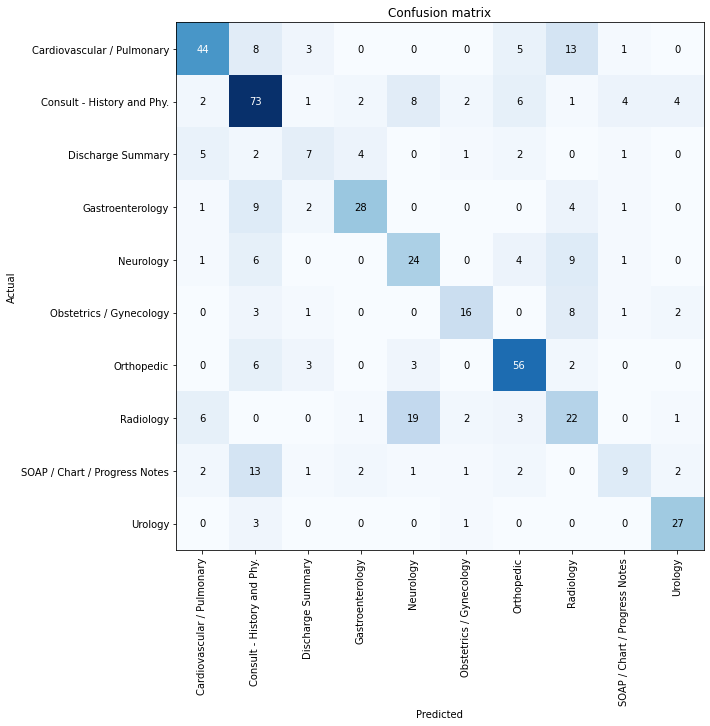

In [61]:
interp.plot_confusion_matrix(figsize=(10,10))

In [62]:
# del(learn)

## Discussion

While 60% - 65% accuracy doesn't sound super high, it can be enough depending on use case. With any use case, you need to think about what task you are solving - going for the highest % accuracy doesn't always mean your NLP/Machine Learning pipeline will suit the desired purpose.

The confusion matrix above shows that some categories have highly similar language and thus are hard to automatically distinguish between the specialties. For example, in the validation/testing set the Neurology and Radiology notes have a high degree of overlap. Similarly, History and Physicals notes often deal with other medical issues so have some overlap with almost every other category.

What are some ways that you might improve accuracy?

* Get more data
* Improve quality of data
* Exclude certain categories/types of notes from automated classification (could be based on words that are found in multiple specialties, based on length, etc.) In the above, Radiology and Neurology would be ideal candidates for human review.
* Use other information to enrich the NLP process (e.g. clinic name, doctor name, billing codes)
